In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'PG Project'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['images', 'data', 'KinectOutputSample', 'DataPreparation.ipynb', 'training_data', 'models', 'Marker_Elicitation.ipynb', 'triaxial_hand_structure_predictor.ipynb']


In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from skimage import color, transform
from skimage.io import imread
from skimage.util import img_as_ubyte, img_as_float
from sklearn.cluster import KMeans

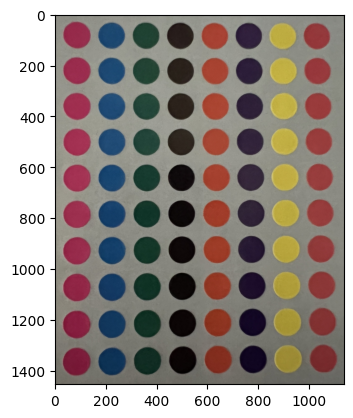

In [4]:
colours = imread(os.path.join(GOOGLE_DRIVE_PATH, 'images/colours.png'))
colours = colours[:, :, :3]
colours = transform.resize(colours, (colours.shape[0]/2, colours.shape[1]/2))


plt.imshow(colours)
plt.show()

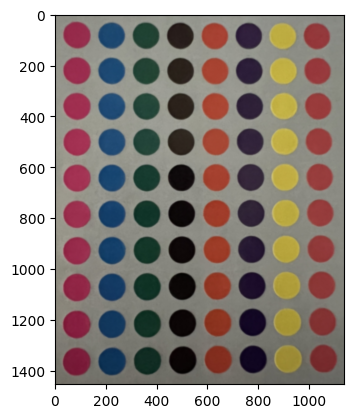

In [5]:
# applying guassiian filter to smoothen colors
kernel_size = (9, 9)

colours = cv2.GaussianBlur(colours, kernel_size, 0)

plt.imshow(colours)
plt.show()

In [6]:
num_clusters = 10

# Convert RGB to HSV color space
rgb_image = colours.copy()

# Reshape the image to a 2D array of pixels
rgb_pixels = rgb_image.reshape(-1, 3)

# Perform K-means clustering
r_kmeans = KMeans(n_clusters=num_clusters, random_state=42)
r_kmeans.fit(rgb_pixels)

# Get the labels assigned to each pixel
rgb_labels = r_kmeans.labels_

# Get the unique labels
rgb_unique_labels = np.unique(rgb_labels)

# Convert RGB to Lab color space
lab_image = color.rgb2lab(colours)

# Reshape the image to a 2D array of pixels
lab_pixels = lab_image.reshape(-1, 3)

# Perform K-means clustering
l_kmeans = KMeans(n_clusters=num_clusters, random_state=42)
l_kmeans.fit(lab_pixels)

# Get the labels assigned to each pixel
lab_labels = l_kmeans.labels_

# Get the unique labels
lab_unique_labels = np.unique(lab_labels)

# Convert RGB to HSV color space
hsv_image = color.rgb2hsv(colours)

# Reshape the image to a 2D array of pixels
hsv_pixels = hsv_image.reshape(-1, 3)

# Perform K-means clustering
h_kmeans = KMeans(n_clusters=num_clusters, random_state=42)
h_kmeans.fit(hsv_pixels)

# Get the labels assigned to each pixel
hsv_labels = h_kmeans.labels_

# Get the unique labels
hsv_unique_labels = np.unique(hsv_labels)



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


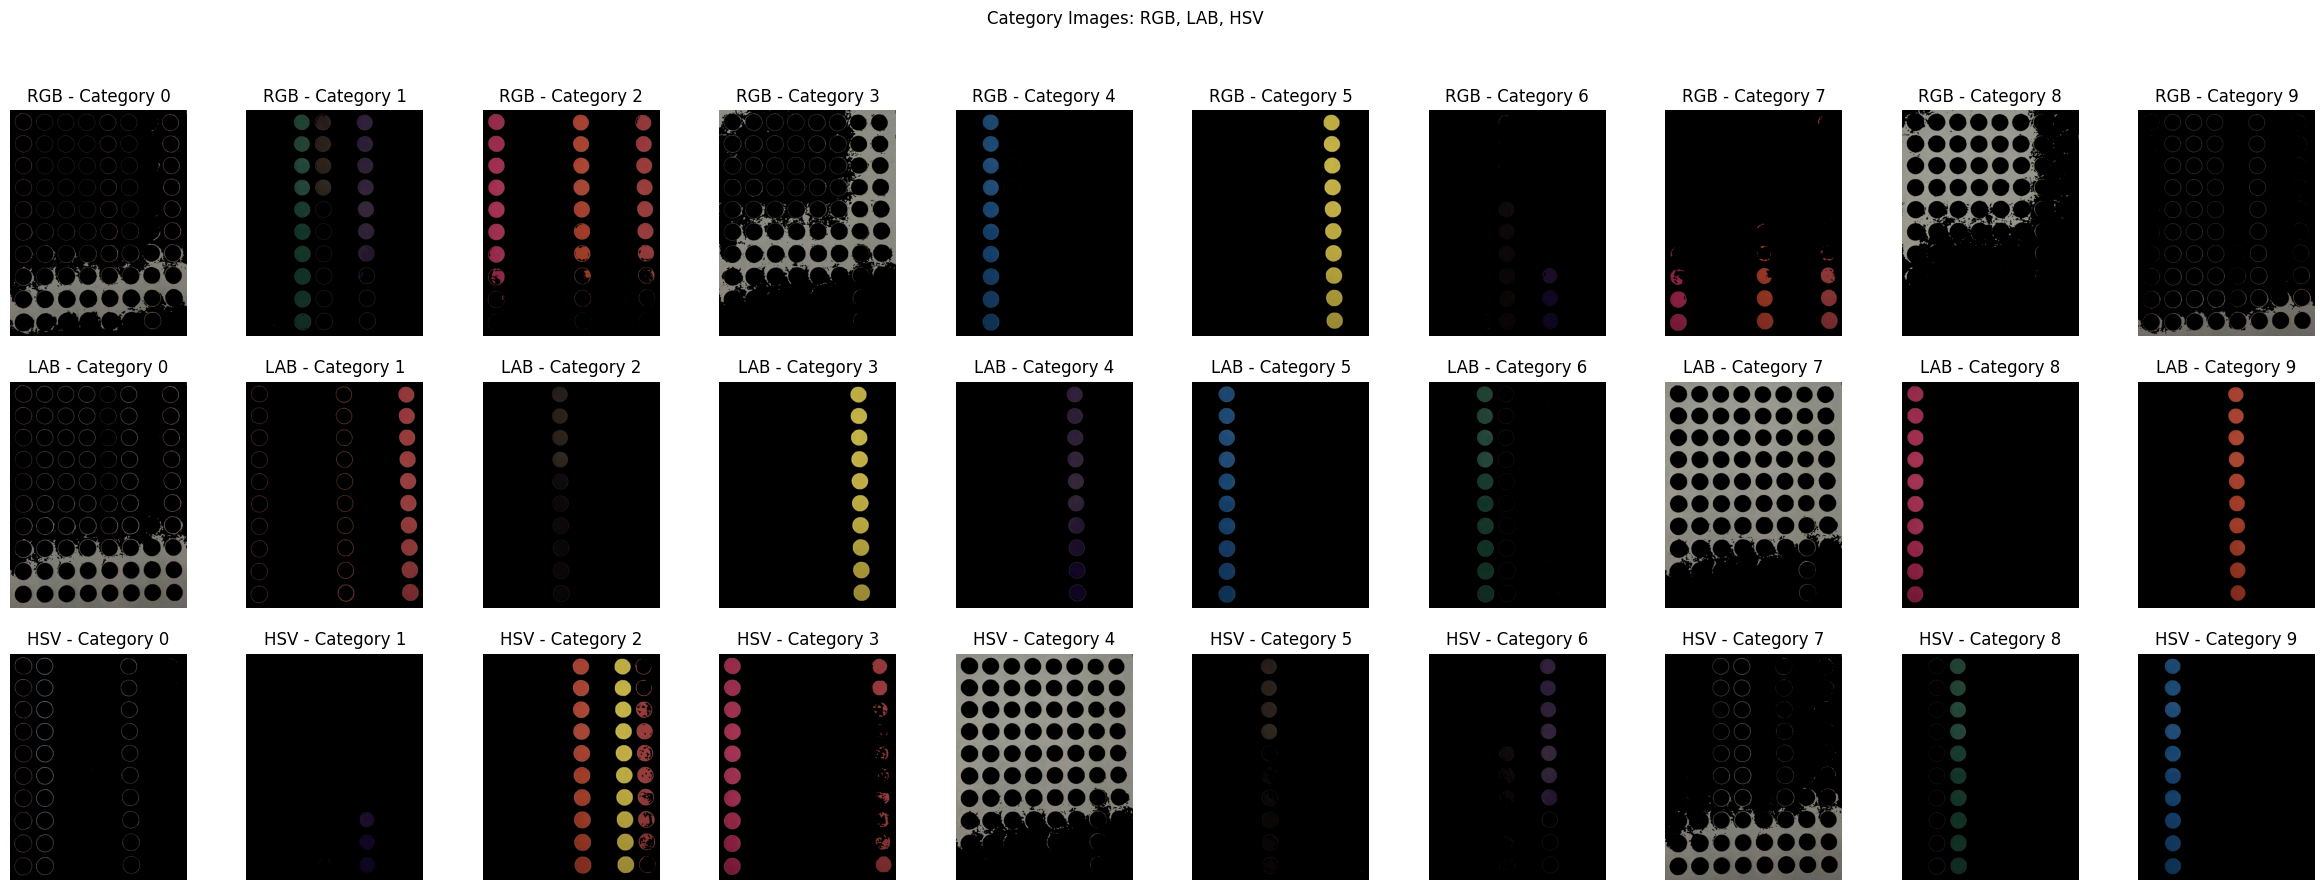

In [7]:
# Create a list of labels for each color space
cat_labels = [rgb_labels, lab_labels, hsv_labels]
n_cat = ['RGB', 'LAB', 'HSV']  # Labels for color spaces
out_images = []

# Loop through each color space
for labels, color_space_name in zip(cat_labels, n_cat):
    for i in range(10):
        cluster_mask = (labels == i)
        segmented_image = np.zeros_like(colours)
        segmented_image[cluster_mask.reshape(colours.shape[:2])] = colours[cluster_mask.reshape(colours.shape[:2])].copy()
        out_images.append(segmented_image)

# Create subplots for all color spaces
fig, axs = plt.subplots(3, 10, figsize=(30, 10))
fig.suptitle('Category Images: RGB, LAB, HSV')

for i, ax in enumerate(axs.flat):
    ax.imshow(out_images[i])
    ax.set_title(f'{n_cat[i // 10]} - Category {i % 10}')
    ax.axis('off')

plt.show()

In [8]:
# Get LAB Ranges
lab_ranges = []
hsv_ranges = []
rgb_ranges = []

multip = 1.2

for x, label in enumerate(lab_unique_labels):
  std_mult1 = 3
  std_mult2 = 3
  std_mult3 = 3


  lab_mask = np.equal(lab_labels, label)
  lab_values = np.array([val for val, flag in zip(lab_pixels, lab_mask) if flag])
  rgb_values = color.lab2rgb(lab_values)
  hsv_values = color.rgb2hsv(rgb_values)

  l_min = np.array([np.mean(lab_values[:, 0]) - np.std(lab_values[:, 0] * std_mult1 * multip),
                 np.mean(lab_values[:, 1]) - np.std(lab_values[:, 1] * std_mult1),
                 np.mean(lab_values[:, 2]) - np.std(lab_values[:, 2] * std_mult1)
                 ])

  l_max = np.array([np.mean(lab_values[:, 0]) + np.std(lab_values[:, 0] * std_mult1 * multip),
                 np.mean(lab_values[:, 1]) + np.std(lab_values[:, 1] * std_mult1),
                 np.mean(lab_values[:, 2]) + np.std(lab_values[:, 2] * std_mult1)
                 ])

  h_min = np.array([np.mean(hsv_values[:, 0]) - np.std(hsv_values[:, 0] * std_mult2),
                 np.mean(hsv_values[:, 1]) - np.std(hsv_values[:, 1] * std_mult2),
                 np.mean(hsv_values[:, 2]) - np.std(hsv_values[:, 2] * std_mult2 * multip)
                 ])

  h_max = np.array([np.mean(hsv_values[:, 0]) + np.std(hsv_values[:, 0] * std_mult2),
                 np.mean(hsv_values[:, 1]) + np.std(hsv_values[:, 1] * std_mult2),
                 np.mean(hsv_values[:, 2]) + np.std(hsv_values[:, 2] * std_mult2 * multip)
                 ])

  r_min = np.array([np.min(rgb_values[:, 0] * 0.6),
                 np.min(rgb_values[:, 1] * 0.6),
                 np.min(rgb_values[:, 2] * 0.6)
                 ])

  r_max = np.array([np.max(rgb_values[:, 0] * 1.4),
                 np.max(rgb_values[:, 1] * 1.4),
                 np.max(rgb_values[:, 2] * 1.4)
                 ])


  lab_ranges.append([l_min, l_max])
  hsv_ranges.append([h_min, h_max])
  rgb_ranges.append([r_min, r_max])
  print(label, 'l', l_min, l_max)
  print(label, 'h', h_min, h_max)
  print(label, 'r', r_min, r_max)

0 l [ 33.38282864 -11.9725493   -4.51789323] [64.21156919 11.91705323 12.77388816]
0 h [-0.34766367 -0.09274571  0.29427742] [0.72982772 0.28256312 0.64573675]
0 r [0.15727115 0.15943437 0.14860632] [0.9569956  0.7351535  0.78983938]
1 l [21.6165215  16.34230522  4.2798942 ] [53.28592827 51.06481554 30.23334186]
1 h [-1.02917332  0.36122274  0.39555972] [1.89442048 0.78921557 0.72450885]
1 r [0.24510876 0.09099599 0.06618216] [0.95481741 0.65718514 0.68711558]
2 l [-14.64346808  -1.14038119  -5.18374814] [29.31620289  5.1382596  10.0113377 ]
2 h [-0.94504344  0.02764633 -0.11902199] [1.58484127 0.77104484 0.31591847]
2 r [6.69339134e-03 1.06661011e-03 8.10773134e-05] [0.3664339 0.3198623 0.3404831]
3 l [50.53273792 -8.36229816 31.85087805] [84.92344899 -2.92820045 69.89091897]
3 h [0.13614264 0.40743054 0.52721195] [0.14790865 0.83849862 0.90462228]
3 r [0.32058289 0.29390828 0.11177694] [1.1492324  1.07959478 0.7359558 ]
4 l [ -9.17290442   3.75882335 -21.18926947] [34.38500677 18.183

In [ ]:
from matplotlib import rc
import matplotlib.animation as animation
rc('animation', html='jshtml')

fig, ax = plt.subplots()

def frame(i):
    ax.clear()
    ax.axis('off')
    fig.tight_layout()

    x = i
    rgb_img = colours.copy()

    # Define the RGB ranges
    rgb_c1 = (rgb_ranges[x][0][0], rgb_ranges[x][1][0])
    rgb_c2 = (rgb_ranges[x][0][1], rgb_ranges[x][1][1])
    rgb_c3 = (rgb_ranges[x][0][2], rgb_ranges[x][1][2])

    # Create the masks for each channel
    rgb_mask1 = np.logical_and(rgb_img[:, :, 0] >= rgb_c1[0], rgb_img[:, :, 0] <= rgb_c1[1])
    rgb_mask2 = np.logical_and(rgb_img[:, :, 1] >= rgb_c2[0], rgb_img[:, :, 1] <= rgb_c2[1])
    rgb_mask3 = np.logical_and(rgb_img[:, :, 2] >= rgb_c3[0], rgb_img[:, :, 2] <= rgb_c3[1])

    lab_img = color.rgb2lab(colours.copy())

    # Define the LAB ranges
    lab_c1 = (lab_ranges[x][0][0], lab_ranges[x][1][0])
    lab_c2 = (lab_ranges[x][0][1], lab_ranges[x][1][1])
    lab_c3 = (lab_ranges[x][0][2], lab_ranges[x][1][2])

    # Create the masks for each channel
    lab_mask1 = np.logical_and(lab_img[:, :, 0] >= lab_c1[0], lab_img[:, :, 0] <= lab_c1[1])
    lab_mask2 = np.logical_and(lab_img[:, :, 1] >= lab_c2[0], lab_img[:, :, 1] <= lab_c2[1])
    lab_mask3 = np.logical_and(lab_img[:, :, 2] >= lab_c3[0], lab_img[:, :, 2] <= lab_c3[1])

    hsv_img = color.rgb2hsv(colours.copy())

    # Define the HSV ranges
    hsv_c1 = (hsv_ranges[x][0][0], hsv_ranges[x][1][0])
    hsv_c2 = (hsv_ranges[x][0][1], hsv_ranges[x][1][1])
    hsv_c3 = (hsv_ranges[x][0][2], hsv_ranges[x][1][2])

    # Create the masks for each channel
    hsv_mask1 = np.logical_and(hsv_img[:, :, 0] >= hsv_c1[0], hsv_img[:, :, 0] <= hsv_c1[1])
    hsv_mask2 = np.logical_and(hsv_img[:, :, 1] >= hsv_c2[0], hsv_img[:, :, 1] <= hsv_c2[1])
    hsv_mask3 = np.logical_and(hsv_img[:, :, 2] >= hsv_c3[0], hsv_img[:, :, 2] <= hsv_c3[1])

    # Combine the masks
    lab_combined_mask = np.sum([lab_mask1, lab_mask2, lab_mask3], axis=0) >= 3
    hsv_combined_mask = np.sum([hsv_mask1, hsv_mask2, hsv_mask3], axis=0) >= 3
    rgb_combined_mask = np.sum([rgb_mask1, rgb_mask2, rgb_mask3], axis=0) >= 3

    # Combine the masks
    combined_mask = np.sum([lab_combined_mask, hsv_combined_mask, rgb_combined_mask], axis=0) >= 2


    image = colours.copy()
    image[~combined_mask] = [255, 255, 255]

    plot=ax.imshow(image)
    return plot

anim = animation.FuncAnimation(fig, frame, frames=9)
plt.close()
anim


Since LAB Kmeans produced the best results

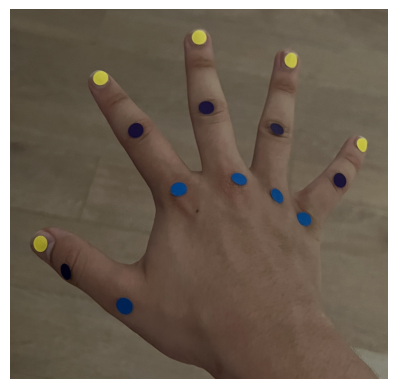

In [ ]:
#load first hand test image
hand_ = imread(os.path.join(GOOGLE_DRIVE_PATH, 'images/H2.png'))
hand_ = hand_[:, :, :3]

plt.imshow(hand_)
plt.axis('off')
plt.show()

In [ ]:
# apply colour segmentation technique
kernel_size2 = (5,5)
spcfic_cats = [3, 4, 5]
colour_segmented_images = []

for i in spcfic_cats:
  x = i
  rgb_img = cv2.GaussianBlur(hand_.copy(), kernel_size2, 0)

  # Define the RGB ranges
  rgb_c1 = (rgb_ranges[x][0][0], rgb_ranges[x][1][0])
  rgb_c2 = (rgb_ranges[x][0][1], rgb_ranges[x][1][1])
  rgb_c3 = (rgb_ranges[x][0][2], rgb_ranges[x][1][2])

  # Create the masks for each channel
  rgb_mask1 = np.logical_and(rgb_img[:, :, 0] >= rgb_c1[0], rgb_img[:, :, 0] <= rgb_c1[1])
  rgb_mask2 = np.logical_and(rgb_img[:, :, 1] >= rgb_c2[0], rgb_img[:, :, 1] <= rgb_c2[1])
  rgb_mask3 = np.logical_and(rgb_img[:, :, 2] >= rgb_c3[0], rgb_img[:, :, 2] <= rgb_c3[1])

  lab_img = color.rgb2lab(cv2.GaussianBlur(hand_.copy(), kernel_size2, 0))

  # Define the LAB ranges
  lab_c1 = (lab_ranges[x][0][0], lab_ranges[x][1][0])
  lab_c2 = (lab_ranges[x][0][1], lab_ranges[x][1][1])
  lab_c3 = (lab_ranges[x][0][2], lab_ranges[x][1][2])

  # Create the masks for each channel
  lab_mask1 = np.logical_and(lab_img[:, :, 0] >= lab_c1[0], lab_img[:, :, 0] <= lab_c1[1])
  lab_mask2 = np.logical_and(lab_img[:, :, 1] >= lab_c2[0], lab_img[:, :, 1] <= lab_c2[1])
  lab_mask3 = np.logical_and(lab_img[:, :, 2] >= lab_c3[0], lab_img[:, :, 2] <= lab_c3[1])

  hsv_img = color.rgb2hsv(cv2.GaussianBlur(hand_.copy(), kernel_size2, 0))

  # Define the HSV ranges
  hsv_c1 = (hsv_ranges[x][0][0], hsv_ranges[x][1][0])
  hsv_c2 = (hsv_ranges[x][0][1], hsv_ranges[x][1][1])
  hsv_c3 = (hsv_ranges[x][0][2], hsv_ranges[x][1][2])

  # Create the masks for each channel
  hsv_mask1 = np.logical_and(hsv_img[:, :, 0] >= hsv_c1[0], hsv_img[:, :, 0] <= hsv_c1[1])
  hsv_mask2 = np.logical_and(hsv_img[:, :, 1] >= hsv_c2[0], hsv_img[:, :, 1] <= hsv_c2[1])
  hsv_mask3 = np.logical_and(hsv_img[:, :, 2] >= hsv_c3[0], hsv_img[:, :, 2] <= hsv_c3[1])

  # Combine the masks
  lab_combined_mask = np.sum([lab_mask1, lab_mask2, lab_mask3], axis=0) >= 3
  hsv_combined_mask = np.sum([hsv_mask1, hsv_mask2, hsv_mask3], axis=0) >= 3
  rgb_combined_mask = np.sum([rgb_mask1, rgb_mask2, rgb_mask3], axis=0) >= 3

  # Combine the masks
  combined_mask = np.sum([lab_combined_mask, hsv_combined_mask, rgb_combined_mask], axis=0) >= 2

  image = hand_.copy()
  image[~lab_combined_mask] = [255, 255, 255]
  colour_segmented_images.append(image)



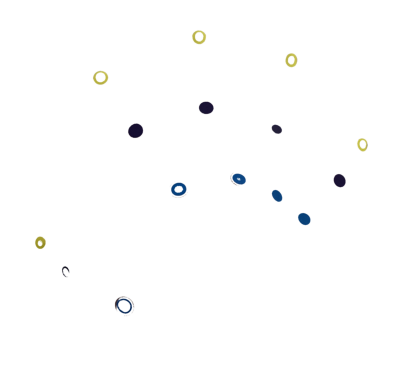

In [ ]:
# show colour segmented image
colour_segmented_image = np.full_like(hand_, 255, dtype=np.uint8)

mask1 = cv2.inRange(colour_segmented_images[0], (0, 0, 0), (254, 254, 254))  # Define your color range
mask2 = cv2.inRange(colour_segmented_images[1], (0, 0, 0), (254, 254, 254))
mask3 = cv2.inRange(colour_segmented_images[2], (0, 0, 0), (254, 254, 254))

colour_segmented_image[mask1 > 0] = colour_segmented_images[0][mask1 > 0]
colour_segmented_image[mask2 > 0] = colour_segmented_images[1][mask2 > 0]
colour_segmented_image[mask3 > 0] = colour_segmented_images[2][mask3 > 0]

plt.imshow(colour_segmented_image)
plt.axis('off')
plt.show()

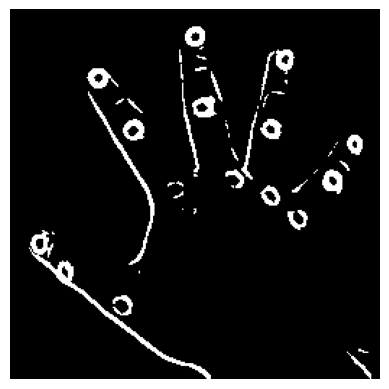

In [ ]:
# edge detection

#apply gaussian blurr
kernel_size2 = (5,5)
resized_hand = cv2.resize(hand_.copy(), (256, 256))
hand_blurr = cv2.GaussianBlur(resized_hand, kernel_size2, 0)

# turn to grayscale
hand_gray = cv2.cvtColor(hand_blurr, cv2.COLOR_RGB2GRAY)

# Apply Sobel edge detection in horizontal direction
sobel_x = cv2.Sobel(hand_gray, cv2.CV_64F, 1, 0, ksize=3)

# Apply Sobel edge detection in vertical direction
sobel_y = cv2.Sobel(hand_gray, cv2.CV_64F, 0, 1, ksize=3)

# Combine the horizontal and vertical edge images
hand_edges = cv2.addWeighted(np.absolute(sobel_x), 0.5, np.absolute(sobel_y), 0.5, 0)

#apply thresholding
_, hand_thrshld = cv2.threshold(hand_edges, 31,255,cv2.THRESH_BINARY)

plt.imshow(color.gray2rgb(hand_thrshld))
plt.axis('off')
plt.show()

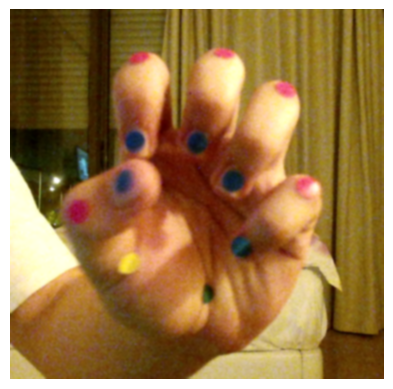

In [11]:
# get second hand test image
hand_2 = imread(os.path.join(GOOGLE_DRIVE_PATH, 'images/266.png'))
hand_2 = hand_2[:, :, :3]
habd2 = hand_2.copy()

# blurr hand
kernel_size = (9, 9)
hand_2 = cv2.GaussianBlur(hand_2, kernel_size, 0)

plt.imshow(hand_2)
plt.axis('off')
plt.show()

In [12]:
spcfic_cats = [3, 5, 6, 8]
colour_segmented_images = []
kernel_size2 = (5,5)
for i in spcfic_cats:
  x = i
  rgb_img = cv2.GaussianBlur(hand_2.copy(), kernel_size2, 0)

  # Define the RGB ranges
  rgb_c1 = (rgb_ranges[x][0][0], rgb_ranges[x][1][0])
  rgb_c2 = (rgb_ranges[x][0][1], rgb_ranges[x][1][1])
  rgb_c3 = (rgb_ranges[x][0][2], rgb_ranges[x][1][2])

  # Create the masks for each channel
  rgb_mask1 = np.logical_and(rgb_img[:, :, 0] >= rgb_c1[0], rgb_img[:, :, 0] <= rgb_c1[1])
  rgb_mask2 = np.logical_and(rgb_img[:, :, 1] >= rgb_c2[0], rgb_img[:, :, 1] <= rgb_c2[1])
  rgb_mask3 = np.logical_and(rgb_img[:, :, 2] >= rgb_c3[0], rgb_img[:, :, 2] <= rgb_c3[1])

  lab_img = color.rgb2lab(cv2.GaussianBlur(hand_2.copy(), kernel_size2, 0))

  # Define the LAB ranges
  lab_c1 = (lab_ranges[x][0][0], lab_ranges[x][1][0])
  lab_c2 = (lab_ranges[x][0][1], lab_ranges[x][1][1])
  lab_c3 = (lab_ranges[x][0][2], lab_ranges[x][1][2])

  # Create the masks for each channel
  lab_mask1 = np.logical_and(lab_img[:, :, 0] >= lab_c1[0], lab_img[:, :, 0] <= lab_c1[1])
  lab_mask2 = np.logical_and(lab_img[:, :, 1] >= lab_c2[0], lab_img[:, :, 1] <= lab_c2[1])
  lab_mask3 = np.logical_and(lab_img[:, :, 2] >= lab_c3[0], lab_img[:, :, 2] <= lab_c3[1])

  hsv_img = color.rgb2hsv(cv2.GaussianBlur(hand_2.copy(), kernel_size2, 0))

  # Define the HSV ranges
  hsv_c1 = (hsv_ranges[x][0][0], hsv_ranges[x][1][0])
  hsv_c2 = (hsv_ranges[x][0][1], hsv_ranges[x][1][1])
  hsv_c3 = (hsv_ranges[x][0][2], hsv_ranges[x][1][2])

  # Create the masks for each channel
  hsv_mask1 = np.logical_and(hsv_img[:, :, 0] >= hsv_c1[0], hsv_img[:, :, 0] <= hsv_c1[1])
  hsv_mask2 = np.logical_and(hsv_img[:, :, 1] >= hsv_c2[0], hsv_img[:, :, 1] <= hsv_c2[1])
  hsv_mask3 = np.logical_and(hsv_img[:, :, 2] >= hsv_c3[0], hsv_img[:, :, 2] <= hsv_c3[1])

  # Combine the masks
  lab_combined_mask = np.sum([lab_mask1, lab_mask2, lab_mask3], axis=0) >= 3
  hsv_combined_mask = np.sum([hsv_mask1, hsv_mask2, hsv_mask3], axis=0) >= 3
  rgb_combined_mask = np.sum([rgb_mask1, rgb_mask2, rgb_mask3], axis=0) >= 3

  # Combine the masks
  combined_mask = np.sum([lab_combined_mask, hsv_combined_mask, rgb_combined_mask], axis=0) >= 2

  image = hand_2.copy()
  image[~lab_combined_mask] = [255, 255, 255]
  colour_segmented_images.append(image)



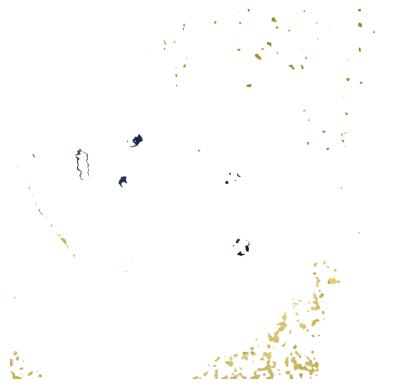

In [13]:
# show colour segmented image
colour_segmented_image = np.full_like(hand_2, 255, dtype=np.uint8)

mask1 = cv2.inRange(colour_segmented_images[0], (0, 0, 0), (254, 254, 254))  # Define your color range
mask2 = cv2.inRange(colour_segmented_images[1], (0, 0, 0), (254, 254, 254))
mask3 = cv2.inRange(colour_segmented_images[2], (0, 0, 0), (254, 254, 254))

colour_segmented_image[mask1 > 0] = colour_segmented_images[0][mask1 > 0]
colour_segmented_image[mask2 > 0] = colour_segmented_images[1][mask2 > 0]
colour_segmented_image[mask3 > 0] = colour_segmented_images[2][mask3 > 0]

plt.imshow(colour_segmented_image)
plt.axis('off')
plt.show()

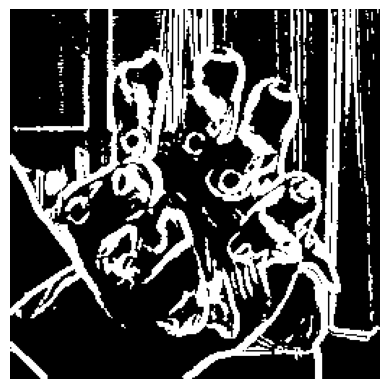

In [14]:
# edge detection on second test image

#apply gaussian blurr
kernel_size2 = (5,5)
resized_hand = cv2.resize(habd2.copy(), (256, 256))
hand_blurr = cv2.GaussianBlur(resized_hand, kernel_size2, 0)

# turn to grayscale
hand_gray = cv2.cvtColor(hand_blurr, cv2.COLOR_RGB2GRAY)

# Apply Sobel edge detection in horizontal direction
sobel_x = cv2.Sobel(hand_gray, cv2.CV_64F, 1, 0, ksize=3)

# Apply Sobel edge detection in vertical direction
sobel_y = cv2.Sobel(hand_gray, cv2.CV_64F, 0, 1, ksize=3)

# Combine the horizontal and vertical edge images
hand_edges = cv2.addWeighted(np.absolute(sobel_x), 0.5, np.absolute(sobel_y), 0.5, 0)

#apply thresholding
_, hand_thrshld = cv2.threshold(hand_edges, 31,255,cv2.THRESH_BINARY)

plt.imshow(color.gray2rgb(hand_thrshld))
plt.axis('off')
plt.show()